# Model Selection

In this notebook, we will:
- [Load the data](#data_collection)
- [Select a SetFit base model](#model_selection)
- [Tune the hyperparameters of the selected base model](#hyper_param)
- [Train the model with the best hyperparameters](#train)
- [Show that our model improves over the baseline](#result)

In [ ]:
# Imports
import pandas as pd
from setfit import SetFitModel, SetFitTrainer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitTrainer
from datasets import Dataset
from setfit import sample_dataset
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
import joblib
import pickle
from optuna.visualization.matplotlib import plot_param_importances
from sklearn.metrics import confusion_matrix
## Workaround for dashes in name
from importlib import import_module
nlbse_statistics = import_module('code-comment-classification.nlbse_statistics') 

tqdm.pandas()

<a id='data_collection'></a>
## Data collection
We first load the data. 
To make the entire process a bit quicker, we only sample 32 instances per class and focus on the depreciation category.

In [ ]:
# Load in the data
df = pd.read_csv('./code-comment-classification/java/input/java.csv')
## Only test deprecation
df = df[df.category == 'deprecation']
df['combo'] = df[['comment_sentence', 'class']].agg(' | '.join, axis=1)
df['label'] = df.instance_type
# Sample 32 instances for quicker training
train_data = sample_dataset(Dataset.from_pandas(df[df.partition == 0]), num_samples=32)
test_data = Dataset.from_pandas(df[df.partition == 1])

<a id='model_selection'></a>

# Model Selection
We tune 4 different models. We then select the best one.

In [ ]:
### FIND BEST MODEL

models_to_test = ['sentence-transformers/paraphrase-MiniLM-L3-v2',
                 'sentence-transformers/all-MiniLM-L6-v2',
                 'sentence-transformers/all-mpnet-base-v2',
                 'flax-sentence-embeddings/st-codesearch-distilroberta-base']
res = []

for model_id in models_to_test:
    model = SetFitModel.from_pretrained(model_id)
    trainer = SetFitTrainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=test_data,
        loss_class=CosineSimilarityLoss,
        num_iterations=20,
        num_epochs=5,
        column_mapping={"combo": "text", "label": "label"},
    )
    trainer.train()
    metrics = trainer.evaluate()
    print(f'{model_id} loss: {metrics}')
    y_hat = model.predict(test_data['combo'])
    y = test_data['label']
    _, fp, fn, tp = confusion_matrix(y_hat, y).ravel()
    precision, recall, f1 = nlbse_statistics.get_precision_recall_f1(tp, fp, fn)
    print(f'precision: {precision}, recall: {recall}, f1 {f1}')
    res.append(f1)
print(res)

## Results
| Model Name                              | Acc         | F1          | Training time |
|-----------------------------------------|-------------|-------------|---------------|
|     paraphrase-MiniLM-L3-v2             |     .877    |     .435    |     1:22      |
|     all-MiniLM-L6-v2                    |     .887    |     .453    |     2:30      |
|     all-mpnet-base-v2                   |     .934    |     .646    |     4:37      |
|     st-codesearch-distilroberta-base    |     .883    |     .457    |     2:41      |

The all-mpnet-base-v2 model performs best. While the training time is slightly increased, it is still relatively quick.

<a id='hyper_param'></a>

## Hyperparameter search
Next we make use of the optuna backend to search for the best hyperparameters.

In [ ]:
## BEST MODEL HYPER PARAM SEARCH

def model_init(params):
    params = params or {}
    max_iter = params.get("max_iter", 100)
    solver = params.get("solver", "liblinear")
    params = {
        "head_params": {
            "max_iter": max_iter,
            "solver": solver,
        }
    }
    return SetFitModel.from_pretrained("sentence-transformers/all-mpnet-base-v2", **params)

def hp_space(trial):  # Training parameters
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "num_epochs": trial.suggest_int("num_epochs", 1, 10),
        "batch_size": trial.suggest_categorical("batch_size", [4, 8, 16, 32, 64]),
        "seed": trial.suggest_int("seed", 1, 40),
        "num_iterations": trial.suggest_categorical("num_iterations", [5, 10, 20]),
        "max_iter": trial.suggest_int("max_iter", 50, 300),
        "solver": trial.suggest_categorical("solver", ["newton-cg", "lbfgs", "liblinear"]),        
    }
trainer = SetFitTrainer(
        train_dataset=train_data,
        eval_dataset=test_data,
        loss_class=CosineSimilarityLoss,
        model_init=model_init,
        column_mapping={"combo": "text", "label": "label"},
    )

In [ ]:
## Save to file 
best_run = trainer.hyperparameter_search(direction="maximize", hp_space=hp_space, n_trials=20)
with open('best_run.pkl', 'wb') as file:
    pickle.dump(best_run, file)

### Plot Parameter Importance
We can see that the learning rate is by far the most important feature.

/tmp/ipykernel_490063/1926739664.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(best_run.backend);


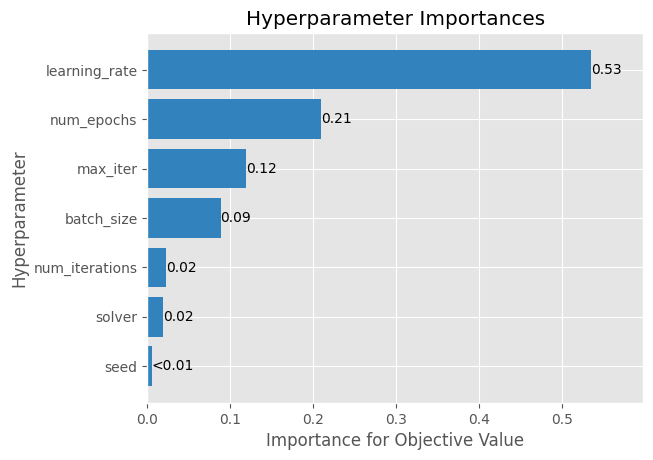

In [54]:
plot_param_importances(best_run.backend)

<a id='train'></a>

## Train Selected Model

We load the selected hyperparameters and the full dataset and train our classifier.

In [ ]:
# Load full dataset and train with best hyperparameters
with open('best_run.pkl', 'rb') as file:
    best_run = pickle.load(file)

df = pd.read_csv('./code-comment-classification/java/input/java.csv')
df = df[df.category == 'deprecation']
df['label'] = df.instance_type
df['combo'] = df[['comment_sentence', 'class']].agg(' | '.join, axis=1)
train_data = Dataset.from_pandas(df[df.partition == 0])
test_data = Dataset.from_pandas(df[df.partition == 1])

trainer = SetFitTrainer(
        train_dataset=train_data,
        eval_dataset=test_data,
        loss_class=CosineSimilarityLoss,
        model_init=model_init,
        column_mapping={"combo": "text", "label": "label"},
    )

best_run.hyperparameters['batch_size'] = 8 # Reduce batch size

trainer.apply_hyperparameters(best_run.hyperparameters, final_model=True)
trainer.train()
# Dump to file 
joblib.dump(trainer, './java_deprecation_all-mpnet-base-v2.joblib')

In [ ]:
## Print score
trainer = joblib.load(f'./java_deprecation_all-mpnet-base-v2.joblib')

y_hat = trainer.model(test_data['combo'])
y = test_data['label']
_, fp, fn, tp = confusion_matrix(y_hat, y).ravel()
precision, recall, f1 = nlbse_statistics.get_precision_recall_f1(tp, fp, fn)
print(f'precision: {precision}, recall: {recall}, f1 {f1}')
wf1 = f1_score(y, y_hat, average='weighted')
print(f'weighted f1: {wf1}')

<a id='result'></a>

## Result 
Our weighted f1 score was: 0,984931778360937

This is an improvement over the baseline of 0,916601 🎊🎊


![display image](https://github.com/snipe/animated-gifs/blob/master/badass-nailed-it/such-good-win.gif?raw=true)

## Conclusion
We now have selected a base-model and we've found the best hyperparameters, with these we have trained a single classifier for one of the categories.

Please join us in the next [Notebook](./2-Creating_classifiers.ipynb) where we train a classifier for each of the 19 categories.